In [1]:
# 数据增强
# 增加一个已有的数据集，使得有更多的多样性
# --在语言里加入各种的背景噪音
# --改变图片的颜色和形状
# 使用增强数据训练
# 使用在线数据生成(随机)
# 测试的时候不进行图像增强
# 相当于正则项

In [2]:
# 翻转(左右,上下)
# 从图片中切割一块，然后变形到固定形状
# --随机高宽比
# --随机大小
# --随机位置
# 颜色
# 改变色调，饱和度，亮度

In [3]:
# 从test set(部署)考虑数据增强
# 数据增强通过变形数据来获取多样性使得模型泛化性更好

In [3]:
# 图像增广
%matplotlib inline 
import torchvision 
from torch import nn 
from d2l import torch as d2l 
import torch

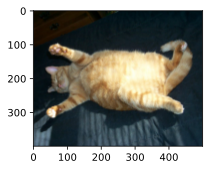

In [5]:
d2l.set_figsize()
img=d2l.Image.open("./d2l-zh/pytorch/img/cat1.jpg")
d2l.plt.imshow(img)

In [7]:
# aug 数据增广函数
# scale 打印大小
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y=[aug(img) for i in range(num_rows*num_cols)]
    d2l.show_images(Y,num_rows,num_cols,scale=scale)

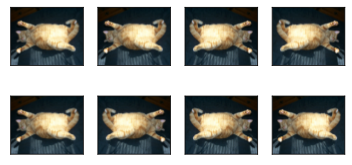

In [8]:
# 水平翻转
apply(img,torchvision.transforms.RandomHorizontalFlip())

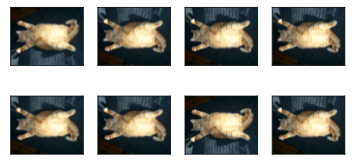

In [10]:
# 垂直翻转
apply(img,torchvision.transforms.RandomVerticalFlip())

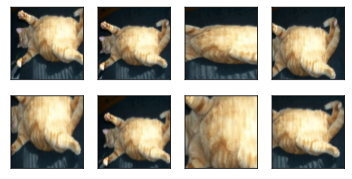

In [12]:
# 随机剪裁
# 输出大小(200,200),数据面积占比(0.1,1),长宽比(0.5,2)
shape_aug=torchvision.transforms.RandomResizedCrop(
    (200,200),scale=(0.1,1),ratio=(0.5,2),
)
apply(img,shape_aug)

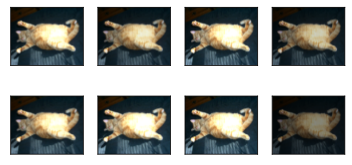

In [22]:
# 随机改变亮度
# 数值是改变的幅度
apply(img,torchvision.transforms.ColorJitter(
    brightness=0.5,contrast=0,saturation=0,hue=0,
))

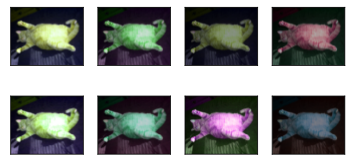

In [23]:
# 改变色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0.5,
))


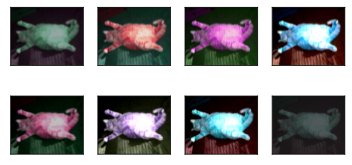

In [24]:
# 随机更改图像的亮度对比度饱和度和色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5,
))


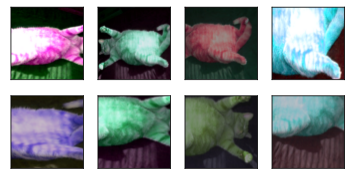

In [25]:
# 结合多种增广
augs=torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ColorJitter(
        brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5,
    ),shape_aug]
)
apply(img,augs)

In [26]:
all_images=torchvision.datasets.CIFAR10(
    train=True,root="",download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../../dataset/CIFAR10\cifar-10-python.tar.gz to ../../../dataset/CIFAR10


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

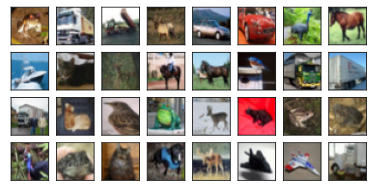

In [27]:
d2l.show_images([
    all_images[i][0] for i in range(32)
],4,8,scale=0.8)

In [37]:
# 只使用最简单的随机左右翻转
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_augs=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
])

In [43]:

def load_cifar10(is_train,augs,batch_size):
    dataset=torchvision.datasets.CIFAR10(
        root="../../../dataset/CIFAR10",download=False,train=is_train,transform=augs,
    )
    dataloader=torch.utils.data.DataLoader(
        dataset,batch_size=batch_size,shuffle=is_train,
        num_workers=d2l.get_dataloader_workers(), # 4
    )
    return dataloader

In [44]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')


In [50]:
batch_size,devices,net=128,d2l.try_all_gpus(),d2l.resnet18(10,3)

def init_weight(m):
    if type(m) in [nn.Linear,nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
        
net.apply(init_weight)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [46]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)


KeyboardInterrupt: 

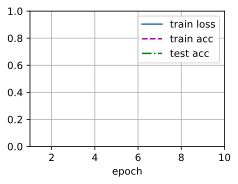

In [51]:
train_with_data_aug(train_augs,test_augs,net)

In [ ]:
train_with_data_aug(test_augs,test_augs,net)